### Notebook for Figure 3 and relevant data, the SCeptre analysis of the 300ms/'medium' dataset.

In [1]:
%matplotlib inline
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import sceptre as spt

## Preparation
Create meta data table and load files into python as "dataset". Alternatively, a meta data table could be created manually and be provided to the function: sceptre.load_dataset()
Mapping is performed with the "File ID" and "Channel" columns.

In [23]:
# create result folder
res_dir = '../results/300ms/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

In [24]:
spt.create_meta_data("../data/300ms/", res_dir)

In [25]:
dataset = spt.load_dataset(proteins = "../data/300ms/300ms_Proteins.txt",
                           psms = "../data/300ms/300ms_PSMs.txt",
                           msms = "../data/300ms/300ms_MSMSSpectrumInfo.txt",
                           files = "../data/300ms/300ms_InputFiles.txt",
                           meta = res_dir + "meta.txt")

In [26]:
# mark and remove potential contaminants
contaminants = pd.read_table('../data/contaminants.txt')['Accession']
dataset['proteins']['contaminant'] = dataset['proteins']['Accession'].isin(contaminants)
dataset['proteins'] = dataset['proteins'][dataset['proteins']['contaminant']==False]

## LC-MS QC
Plot various visualizations that inform about the quality of each LC-MS run.

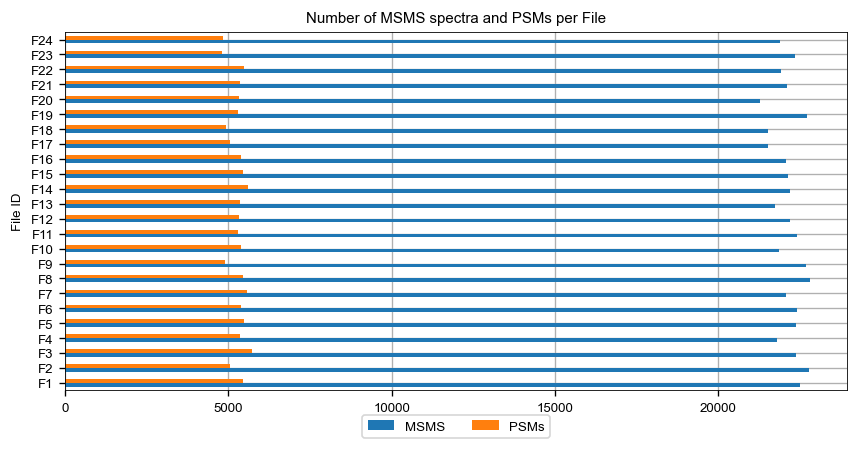

In [27]:
spt.plot_psms_msms(dataset)
plt.savefig(res_dir + "psms_msms.pdf", bbox_inches='tight', transparent=True)

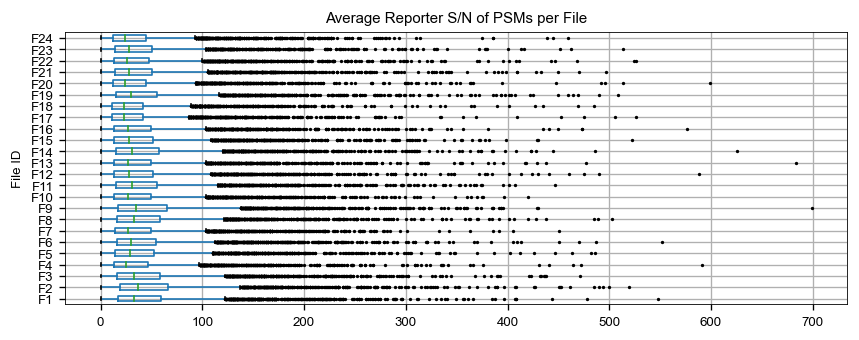

In [28]:
spt.plot_avg_sn(dataset)
plt.savefig(res_dir + "avg_sn.pdf", bbox_inches='tight', transparent=True)

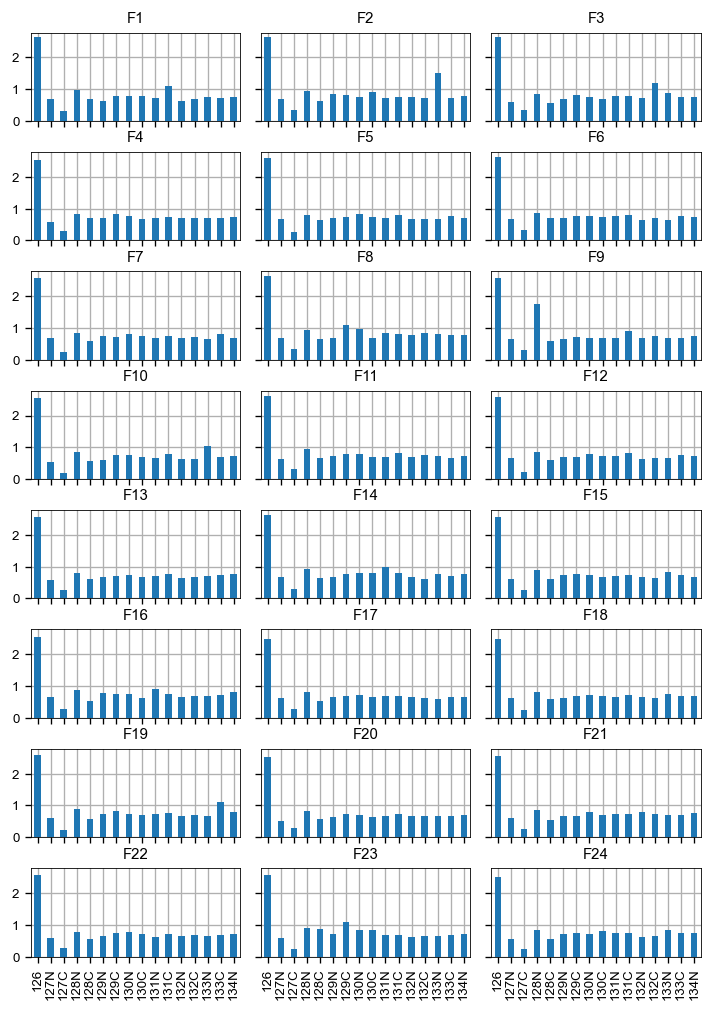

In [29]:
spt.plot_set_overview(dataset)
plt.savefig(res_dir + "set_overview.pdf", bbox_inches='tight', transparent=True)

In [30]:
s_c_channels = ['127N', '128N', '128C', '129N', '129C', '130N', '130C',
                '131N','131C', '132N', '132C', '133N', '133C', '134N']
spt.print_ms_stats(dataset, s_c_channels=s_c_channels)

Protein IDs: 2076
Peptide IDs: 11111
PSMs: 127196
PSM rate: 0.239
Median of median S/N in single-cell channels: 5.4
Median of mean S/N in single-cell channels: 7.777
Median S/N of booster channel: 376.6
Mean protein IDs per file: 1287.167


## Load data into Scanpy

In [31]:
adata = spt.dataset_to_scanpy(dataset)

In [32]:
# transform meta columns to categories
adata.obs["Column"] = adata.obs["Column"].astype(pd.Int64Dtype()).astype("category")
adata.obs["Plate"] = adata.obs["Plate"].astype(str).astype("category")
# object columns to category
adata.obs.loc[:, adata.obs.dtypes == "object"] = adata.obs.select_dtypes(["object"]
                                                                          ).apply(lambda x: x.astype("category"))
# order some columns
adata.obs["File ID"] = adata.obs["File ID"].cat.reorder_categories(adata.obs["File ID"].unique(), ordered=True)
adata.obs["Channel"] = adata.obs["Channel"].cat.reorder_categories(adata.obs["Channel"].unique(), ordered=True)

# normalize facs parameter between 0 and 1
fasc_params = ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'APC-Cy7-A', 'PE-A']
adata.obs[fasc_params] = adata.obs[fasc_params].apply(lambda x: (x-x.min())/(x-x.min()).max())
# rename the facs parameter
adata.obs = adata.obs.rename(columns={'APC-Cy7-A': 'CD34 APC-Cy7-A', 'PE-A': 'CD38 PE-A'})

# set colors for gated and sorted populations
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
adata.uns['Sorted Population_colors'] = [cols[0], cols[1], cols[2]]
adata.uns['Gated Population_colors'] = [cols[3], cols[0], cols[1], cols[2]]

## Filter samples, channels and groups of cells

In [33]:
# remove non-single-cell channels
adata = adata[adata.obs['Channel'] != '126'].copy()
adata = adata[adata.obs['Channel'] != '127C'].copy()

/home/bfurtwa/miniconda3/envs/sceptre_test/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Normalization

In [34]:
spt.normalize(adata)

performed 22 iterations
456 values below 1.1 were set to 0
filtered out 13 genes that are detected in less than 1 cells


## Cell QC

34 of 336 cells do not pass filter


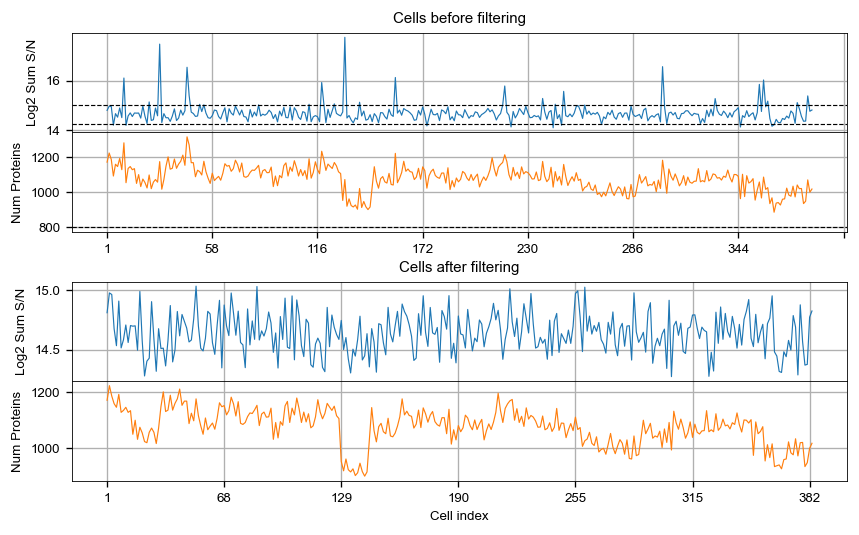

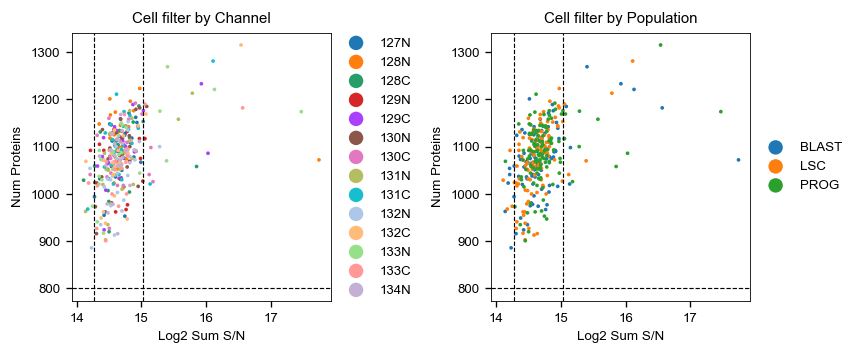

In [35]:
figs = spt.calculate_cell_filter(adata, thresh_sum=2, min_proteins=800)
figs[0].savefig(res_dir + "cell_filter_1.pdf", bbox_inches='tight', transparent=True)
figs[1].savefig(res_dir + "cell_filter_2.pdf", bbox_inches='tight', transparent=True)

In [36]:
spt.apply_cell_filter(adata)

removed 34 cells
filtered out 51 genes that are detected in less than 3 cells


## Batch QC

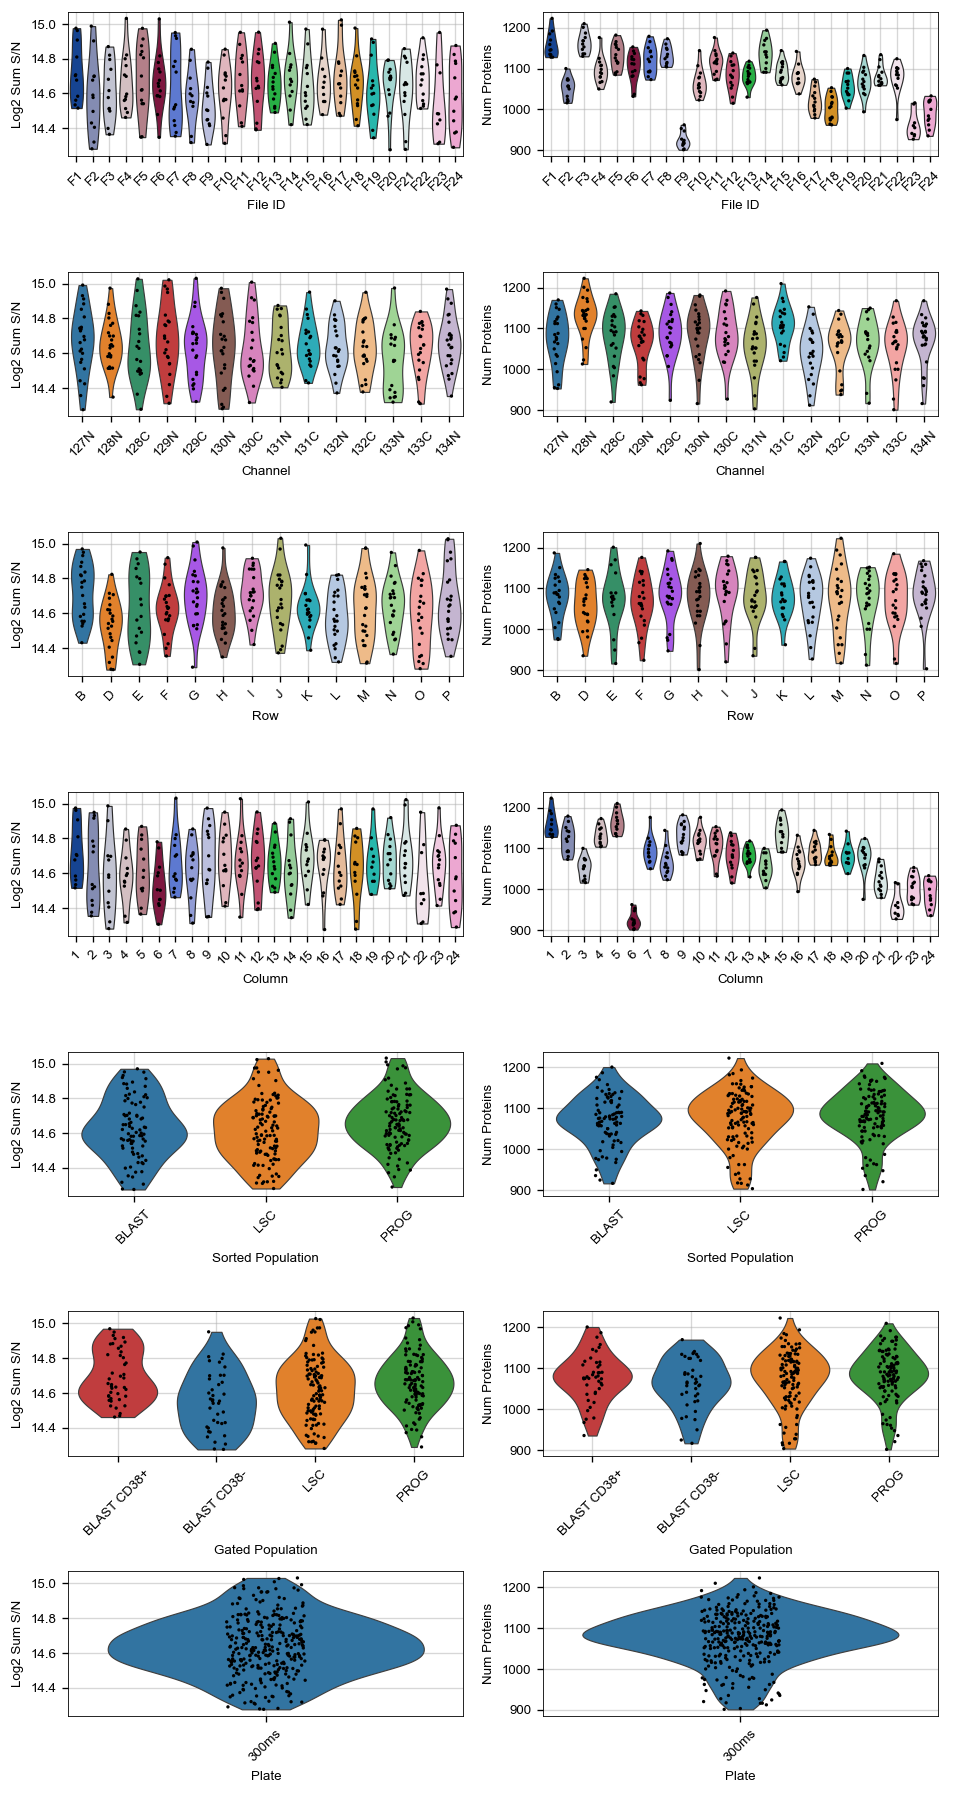

In [37]:
spt.plot_batch_qc(adata)
plt.savefig(res_dir + "batch_qc.pdf", bbox_inches='tight', transparent=True)

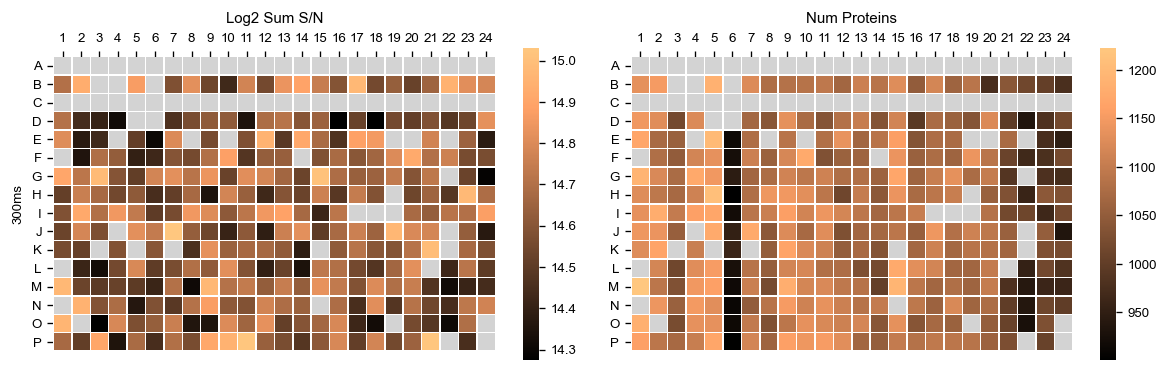

In [38]:
spt.plot_plate_qc(adata)
plt.savefig(res_dir + "plate_qc.pdf", bbox_inches='tight', transparent=True)

mean protein IDs per cell: 1076.0
median protein IDs per cell: 1082.5
percent missing values: 45.82


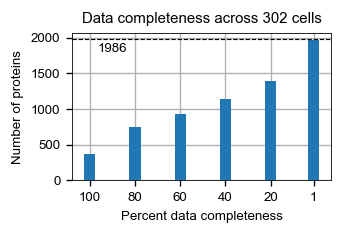

In [39]:
spt.plot_data_completeness(adata)
plt.savefig(res_dir + "data_completeness.pdf", bbox_inches='tight', transparent=True)

/mnt/c/Users/qlj874/OneDrive - Københavns Universitet/Documents/SCeptre/sceptre/sceptre.py:1056: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


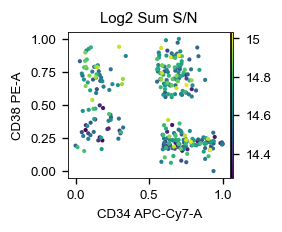

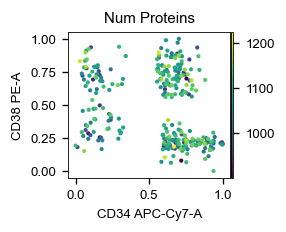

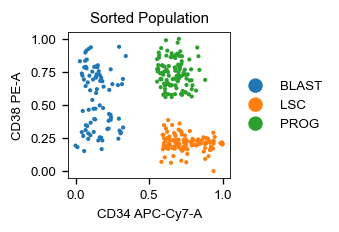

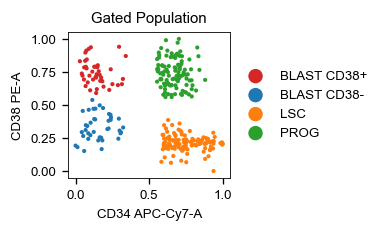

In [40]:
figs = spt.plot_facs_qc(adata, 'CD34 APC-Cy7-A', 'CD38 PE-A')
for i, f in enumerate(figs):
    f.savefig(res_dir + "facs_qc_{}.pdf".format(i), bbox_inches='tight', transparent=True)

## Prepare Embedding

In [41]:
# median shift of total intensity across cells
sc.pp.normalize_total(adata, exclude_highly_expressed=True) 
# log2(x+1) transformation
sc.pp.log1p(adata, base=2)
# save the normalized and log2 transformed data as raw data for differential expression testing
adata.raw = adata

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['S100A8', 'DCD']
    finished (0:00:00)


In [42]:
adata.X

array([[7.466915 , 7.306583 , 6.9667854, ..., 0.       , 0.       ,
        0.       ],
       [7.395968 , 8.06957  , 6.743993 , ..., 0.       , 0.       ,
        0.       ],
       [7.4769115, 7.527594 , 6.741769 , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [7.627979 , 7.9211354, 6.896495 , ..., 0.       , 0.       ,
        2.8482432],
       [7.653557 , 7.999382 , 6.763465 , ..., 0.       , 0.       ,
        3.286941 ],
       [7.763692 , 7.506684 , 6.911528 , ..., 0.       , 0.       ,
        3.2759871]], dtype=float32)

impute_knn: 1/1
	fraction filter: 1/11
	fraction filter: 2/11
	fraction filter: 3/11
	fraction filter: 4/11
	fraction filter: 5/11
	fraction filter: 6/11
	fraction filter: 7/11
	fraction filter: 8/11
	fraction filter: 9/11
	fraction filter: 10/11
	fraction filter: 11/11


impute_knn  Fraction of valid values filter embedding_knn  Silhouette Score
3           5                              0.3            15          0.210777
0           5                              0.0            15          0.197837
10          5                              1.0            15          0.193433
8           5                              0.8            15          0.191224
9           5                              0.9            15          0.189675
2           5                              0.2            15          0.189411
1           5                              0.1            15          0.184598
4           5                              0.4            15          0.182888
7           5                              0.7            15          0.178127
5           5                              0.5            15          0.164255
6           5                              0.6            15          0.162474

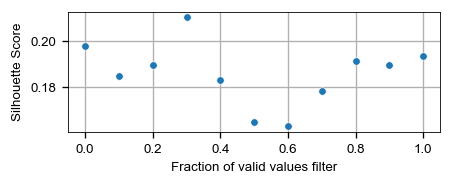

In [43]:
# find the best parameters for the embedding based on celltype separation
# Note that from here on, the code might not be 100% reproducible when changing between computer systems / hardware
# See: https://github.com/theislab/single-cell-tutorial/issues/36#issuecomment-622965632

save_path = '../results/300ms/find_embedding/'
if os.path.exists(save_path):
    shutil.rmtree(save_path)
os.makedirs(save_path)

scores = spt.find_embedding_params(adata, use_rep='umap', save_path=save_path)
plt.savefig(res_dir + "find_embedding_params.pdf", bbox_inches='tight', transparent=True)
scores

In [44]:
# apply fraction of valid values filter
adata = adata[:, (adata.X != 0).sum(axis=0) >= adata.obs.shape[0]*0.3].copy()
spt.impute(adata)
# scale to unit variance and zero mean
sc.pp.scale(adata)
adata

AnnData object with n_obs × n_vars = 302 × 1246
    obs: 'File ID', 'Channel', 'File Name', 'Plate', 'Sample', 'Row', 'Column', 'Well', 'Sorted Population', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'CD34 APC-Cy7-A', 'CD38 PE-A', 'Time', 'Gated Population', 'Num Proteins', 'Log2 Sum S/N', 'Pass Cell Filter'
    var: 'Accession', 'Description', 'Biological Process', 'Cellular Component', 'Molecular Function', 'KEGG Pathways', 'Reactome Pathways', 'WikiPathways', 'n_cells', 'mean', 'std'
    uns: 'Sorted Population_colors', 'Gated Population_colors', 'Channel_colors', 'File ID_colors', 'Row_colors', 'Column_colors', 'Plate_colors', 'log1p'

### Heatmap

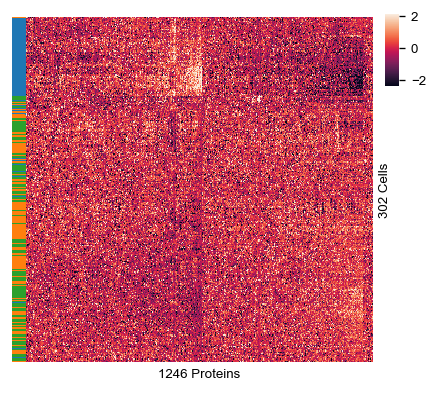

In [45]:
ax = sc.pl.clustermap(adata, obs_keys='Sorted Population', metric='correlation',
                      use_raw=False, robust=True, xticklabels=False, yticklabels=False,
                      show=False, cbar_pos=(0.995, .645, .03, .15), figsize=(4, 4))
p = ax.ax_heatmap.set(xlabel='{} Proteins'.format(adata.shape[1]), ylabel='{} Cells'.format(adata.shape[0]))
ax.ax_row_dendrogram.set_visible(False)
ax.ax_col_dendrogram.set_visible(False)
#plt.savefig(res_dir + "heatmap.pdf", bbox_inches='tight', transparent=True) # takes very long

In [46]:
plot_parameters = ['Sorted Population', 'Gated Population', 'File ID', 'Channel', 'Plate',
                   'Row', 'Column', 'Num Proteins', 'Log2 Sum S/N', 'Time', 'FSC-A', 'FSC-H',
                   'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'CD34 APC-Cy7-A', 'CD38 PE-A']
# set cmaps for plot parameters
plot_cmaps = {'Num Proteins': 'copper', 'Log2 Sum S/N': 'copper', 'Time': 'copper',
             'FSC-A': 'cividis', 'FSC-H': 'cividis', 'FSC-W': 'cividis', 'SSC-A': 'cividis',
             'SSC-H': 'cividis', 'SSC-W': 'cividis', 'CD34 APC-Cy7-A': 'cividis', 'CD38 PE-A': 'cividis'}

# plotting options for panels
figsize = (9, 15.5)
wspace = 1
hspace = 0.7
cellsize= 30 # size to plot cells

## PCA

In [47]:
sc.pp.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:00)


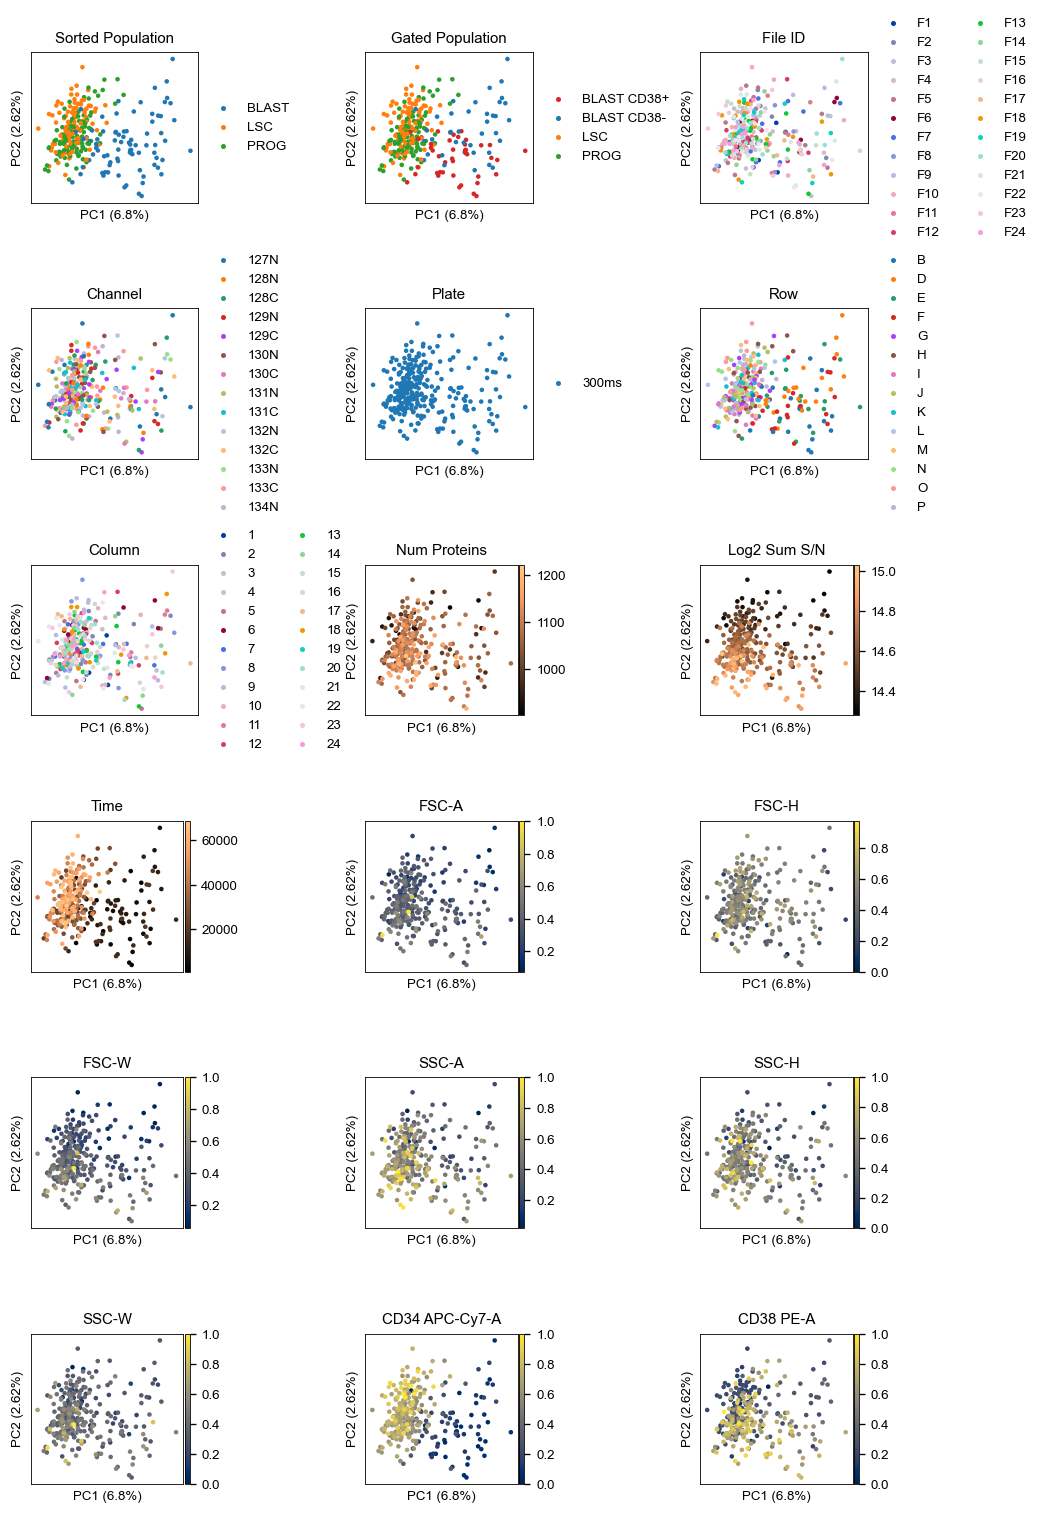

In [48]:
fig = plt.figure(figsize=figsize)
for i, p in enumerate(plot_parameters):
    ax = fig.add_subplot(6, 3, i+1)
    cmap = plot_cmaps[p] if p in plot_cmaps else None
    sc.pl.pca(adata, color=p, size=cellsize, cmap=cmap, show=False, ax=ax, annotate_var_explained=True)
plt.subplots_adjust(wspace=wspace, hspace=hspace)
fig.savefig(res_dir + "pca.pdf", bbox_inches='tight', transparent=True)

## Embedding of the neighborhood graph

In [49]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:00)


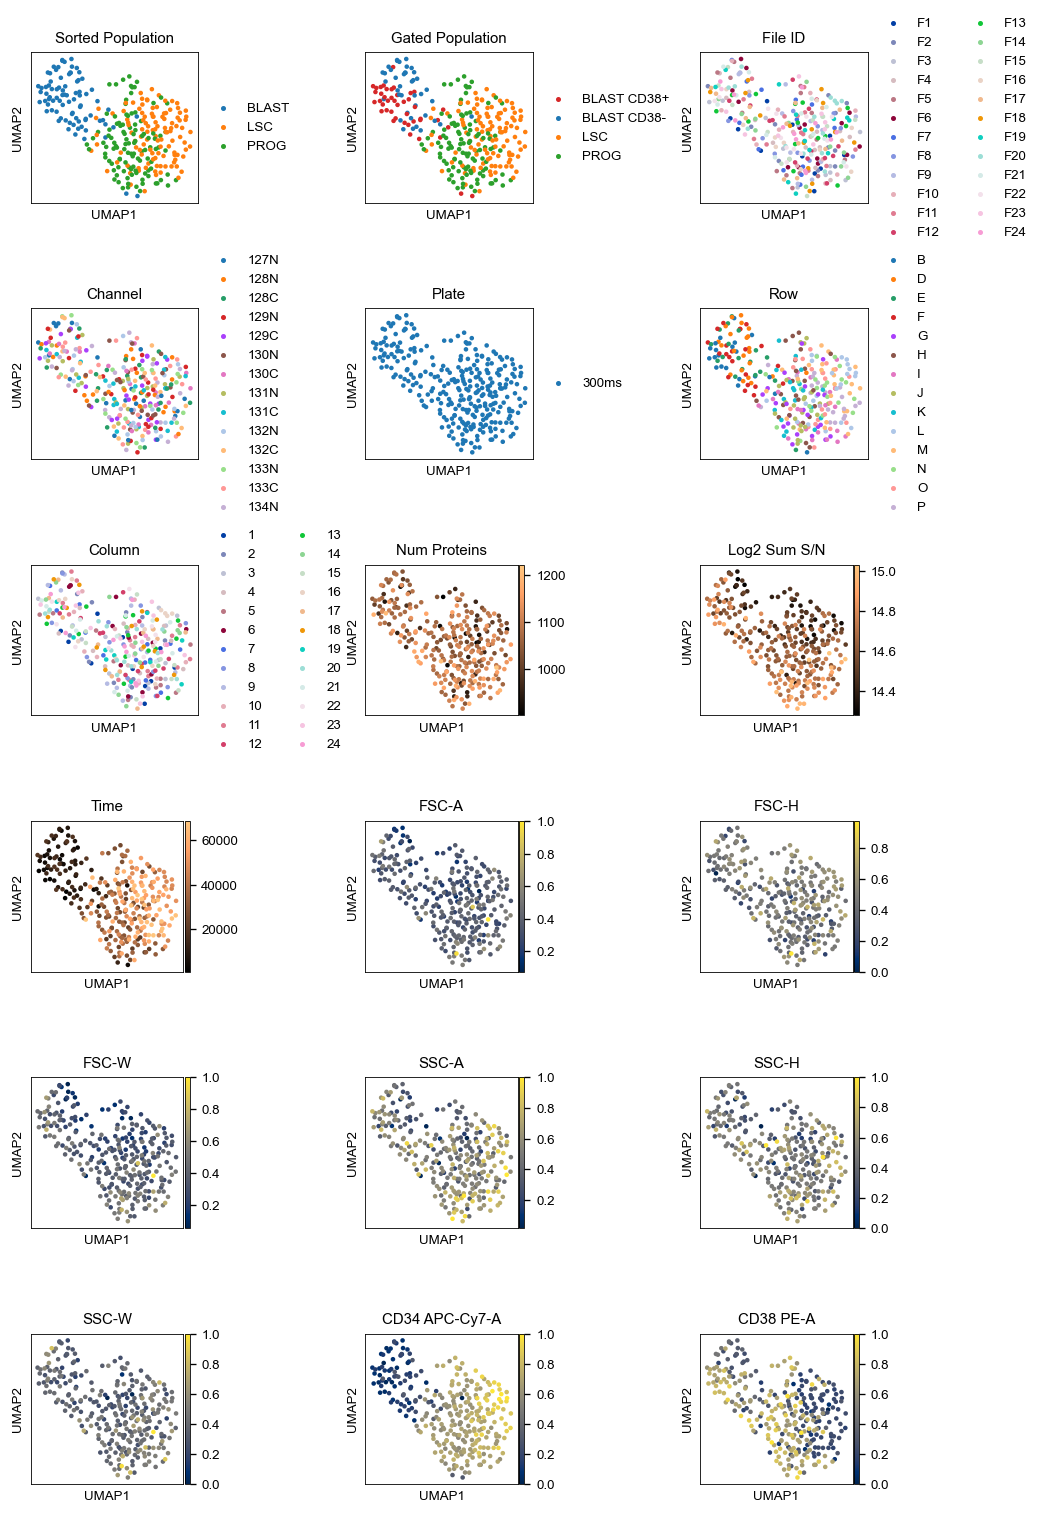

In [50]:
fig = plt.figure(figsize=figsize)
for i, p in enumerate(plot_parameters):
    ax = fig.add_subplot(6, 3, i+1)
    cmap = plot_cmaps[p] if p in plot_cmaps else None
    sc.pl.umap(adata, color=p, size=cellsize, cmap=cmap, show=False, ax=ax)
plt.subplots_adjust(wspace=wspace, hspace=hspace)
fig.savefig(res_dir + "umap.pdf", bbox_inches='tight', transparent=True)

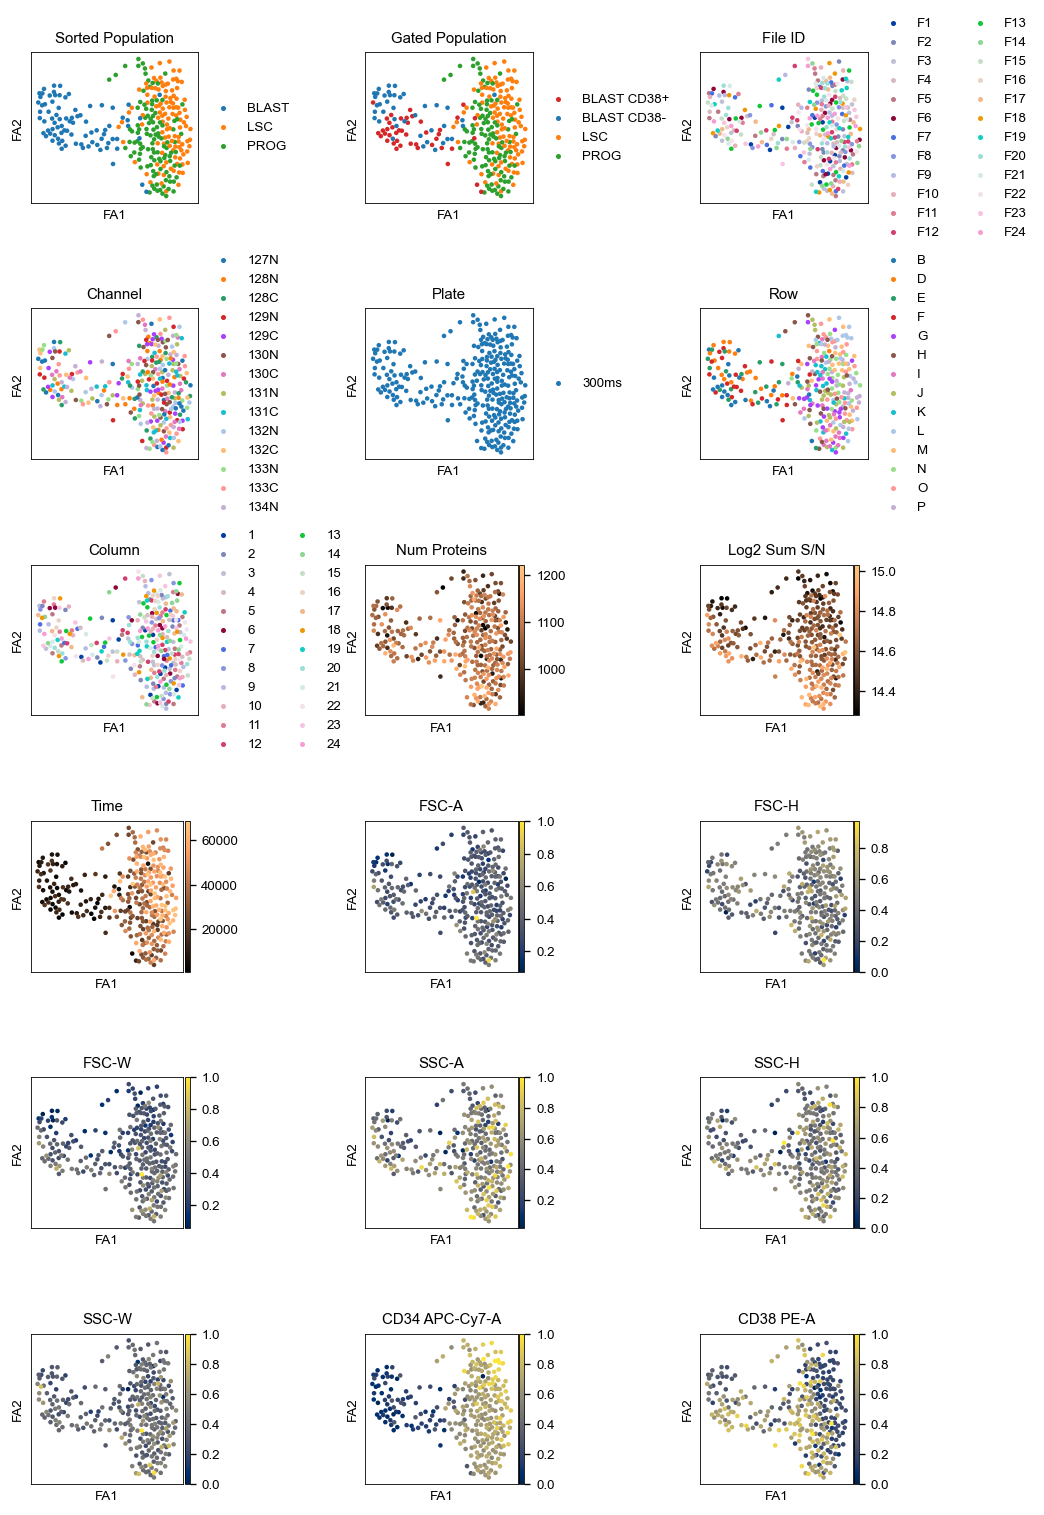

In [51]:
fig = plt.figure(figsize=figsize)
for i, p in enumerate(plot_parameters):
    ax = fig.add_subplot(6, 3, i+1)
    cmap = plot_cmaps[p] if p in plot_cmaps else None
    sc.pl.draw_graph(adata, color=p, size=cellsize, cmap=cmap, show=False, ax=ax)
plt.subplots_adjust(wspace=wspace, hspace=hspace)
fig.savefig(res_dir + "fa.pdf", bbox_inches='tight', transparent=True)

## Test differential expression between sorted populations

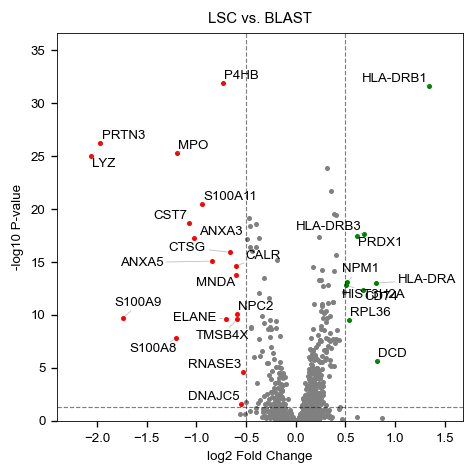

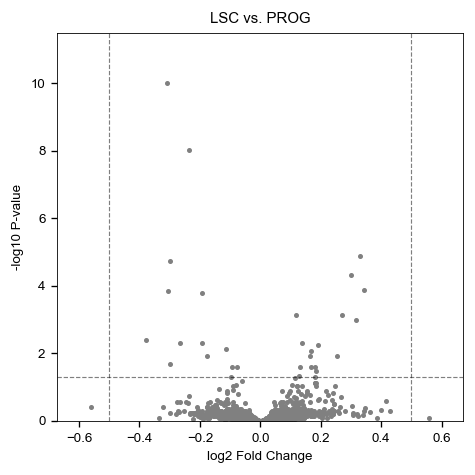

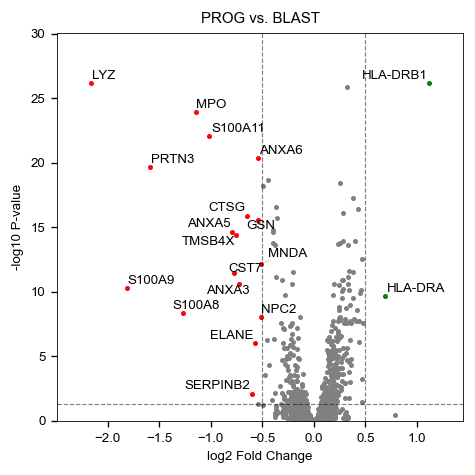

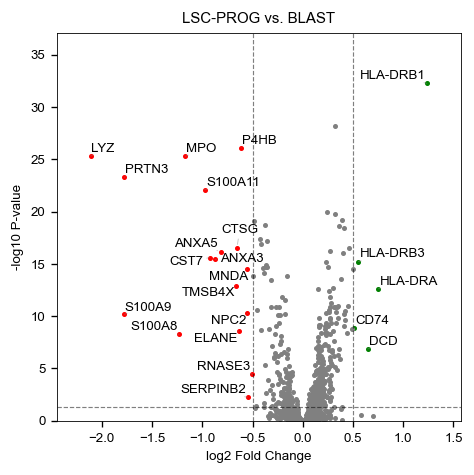

In [52]:
spt.de_test(adata, by='Sorted Population', group1='LSC', group2='BLAST', key='LSC_vs_BLAST')
spt.de_test(adata, by='Sorted Population', group1='LSC', group2='PROG', key='LSC_vs_PROG')
spt.de_test(adata, by='Sorted Population', group1='PROG', group2='BLAST', key='PROG_vs_BLAST')
# create group LSC-PROG vs. BLAST
adata.obs['concat_groups'] = adata.obs['Sorted Population'].apply(
    lambda x: 'BLAST' if x=='BLAST' else 'LSC-PROG').astype('category')

spt.de_test(adata, by='concat_groups', group1='LSC-PROG', group2='BLAST', key='LSC_PROG_vs_BLAST')

spt.plot_volcano(adata, test_key='LSC_vs_BLAST')
plt.savefig(res_dir + "volcano_LSC_vs_BLAST.pdf", bbox_inches='tight', transparent=True)
spt.plot_volcano(adata, test_key='LSC_vs_PROG')
plt.savefig(res_dir + "volcano_LSC_vs_PROG.pdf", bbox_inches='tight', transparent=True)
spt.plot_volcano(adata, test_key='PROG_vs_BLAST')
plt.savefig(res_dir + "volcano_PROG_vs_BLAST.pdf", bbox_inches='tight', transparent=True)
spt.plot_volcano(adata, test_key='LSC_PROG_vs_BLAST')
plt.savefig(res_dir + "volcano_LSC_PROG_vs_BLAST.pdf", bbox_inches='tight', transparent=True)

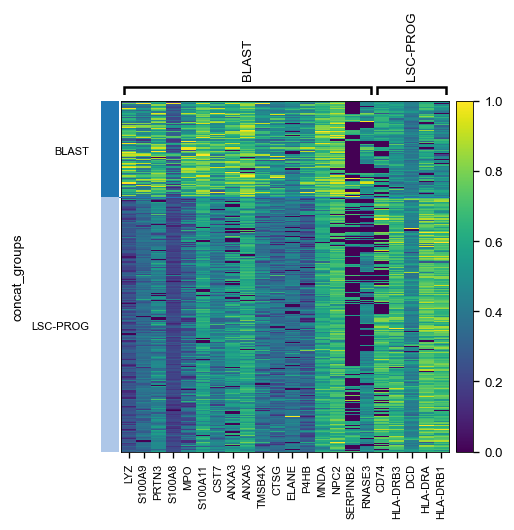

In [53]:
spt.plot_de_heatmap(adata, test_key='LSC_PROG_vs_BLAST')
plt.savefig(res_dir + "heatmap_LSC_PROG_vs_BLAST.pdf", bbox_inches='tight', transparent=True)

In [54]:
# get the de-genes
de_g = adata.uns['LSC_PROG_vs_BLAST']['results']
genes_up = de_g[(de_g['pval_adj'] <= 0.05) & (de_g['log2foldchange'] >= 0.5)]['gene']
genes_down = de_g[(de_g['pval_adj'] <= 0.05) & (de_g['log2foldchange'] <= -0.5)]['gene']

In [55]:
# test for enriched terms
spt.enrichment_test(adata, gene_set=genes_up,
                    categories=['Biological Process', 'Cellular Component', 'Molecular Function',
                                'KEGG Pathways', 'Reactome Pathways', 'WikiPathways'], key='LSC-PROG Terms')
spt.enrichment_test(adata, gene_set=genes_down,
                    categories=['Biological Process', 'Cellular Component', 'Molecular Function',
                                'KEGG Pathways', 'Reactome Pathways', 'WikiPathways'], key='BLAST Terms')

In [56]:
adata.uns['LSC-PROG Terms'].to_csv(res_dir + "enriched_terms_lsc_prog.csv")
adata.uns['LSC-PROG Terms']

size background  \
 Translocation of ZAP-70 to Immunological synapse           1986.0   
 Phosphorylation of CD3 and TCR zeta chains                 1986.0   
Allograft Rejection                                         1986.0   
PD-1 signaling                                              1986.0   
 Generation of second messenger molecules                   1986.0   
 Interferon gamma signaling                                 1986.0   
 Cytokines and Inflammatory Response                        1986.0   
 Antigen processing and presentation                        1986.0   
 MHC class II antigen presentation                          1986.0   
vacuole                                                     1986.0   
 Tuberculosis                                               1986.0   
 Intestinal immune network for IgA production               1986.0   
 Staphylococcus aureus infection                            1986.0   
 Asthma                                                     1986.0   
 Allograft rejection                                        1986.0   
 Autoimmune thyroid disease                                 1986.0   
 Graft-versus-host disease                                  1986.0   
endosome                                                    1986.0   
 Type I diabetes mellitus                                   1986.0   
 Hematopoietic cell lineage                                 1986.0   
 Downstream TCR signaling                                   1986.0   
Golgi                                                       1986.0   
 Cell adhesion molecules (CAMs)                             1986.0   
receptor activity                                           1986.0   
 Viral myocarditis                                          1986.0   
 Rheumatoid arthritis                                       1986.0   
cell surface                                                1986.0   
 Th1 and Th2 cell differentiation                           1986.0   
 Leishmaniasis                                              1986.0   
 Systemic lupus erythematosus                               1986.0   
signal transducer activity                                  1986.0   
endoplasmic reticulum                                       1986.0   
 Toxoplasmosis                                              1986.0   
 Herpes simplex infection                                   1986.0   
 HTLV-I infection                                           1986.0   
 Phagosome                                                  1986.0   
MHC class II antigen presentation                           1986.0   
Inflammatory bowel disease (IBD)                            1986.0   
 Epstein-Barr virus infection                               1986.0   
Influenza A                                                 1986.0   
Antimicrobial peptides                                      1986.0   
 Inflammatory bowel disease (IBD)                           1986.0   
 Cell surface interactions at the vascular wall             1986.0   
Herpes simplex infection                                    1986.0   

                                                   # in background  \
 Translocation of ZAP-70 to Immunological synapse              4.0   
 Phosphorylation of CD3 and TCR zeta chains                    5.0   
Allograft Rejection                                            6.0   
PD-1 signaling                                                 6.0   
 Generation of second messenger molecules                      8.0   
 Interferon gamma signaling                                   12.0   
 Cytokines and Inflammatory Response                           2.0   
 Antigen processing and presentation                          15.0   
 MHC class II antigen presentation                            37.0   
vacuole                                                       83.0   
 Tuberculosis                                                 29.0   
 Intestinal immune network for IgA production               

In [57]:
adata.uns['BLAST Terms'].to_csv(res_dir + "enriched_terms_blast.csv")
adata.uns['BLAST Terms']

size background  \
extracellular                                                1986.0   
organelle lumen                                              1986.0   
defense response                                             1986.0   
response to stimulus                                         1986.0   
Neutrophil degranulation                                     1986.0   
Antimicrobial peptides                                       1986.0   
 Antimicrobial peptides                                      1986.0   
 Regulation of TLR by endogenous ligand                      1986.0   
 Metal sequestration by antimicrobial proteins               1986.0   
transport                                                    1986.0   
 Neutrophil degranulation                                    1986.0   
 Chylomicron assembly                                        1986.0   
 Regulation of Insulin-like Growth Factor (IGF)...           1986.0   
 Regulation of Complement cascade                            1986.0   
Platelet degranulation                                       1986.0   
Activation of Matrix Metalloproteinases                      1986.0   
 Collagen biosynthesis and modifying enzymes                 1986.0   
 VLDL assembly                                               1986.0   
 Activation of Matrix Metalloproteinases                     1986.0   
Transcriptional misregulation in cancer                      1986.0   
 Metabolism of Angiotensinogen to Angiotensins               1986.0   
Collagen degradation                                         1986.0   
 Common Pathway of Fibrin Clot Formation                     1986.0   
 Benzene metabolism                                          1986.0   
ACE Inhibitor Pathway                                        1986.0   
TarBasePathway                                               1986.0   
Blood Clotting Cascade                                       1986.0   
IL1 and megakaryocytes in obesity                            1986.0   
 Systemic lupus erythematosus                                1986.0   
Lysosome                                                     1986.0   
Asthma                                                       1986.0   
cellular component movement                                  1986.0   
Salivary secretion                                           1986.0   
 Neuroactive ligand-receptor interaction                     1986.0   
 Other interleukin signaling                                 1986.0   
 Interleukin-12 family signaling                             1986.0   
 LDL clearance                                               1986.0   
Dissolution of Fibrin Clot                                   1986.0   
 Renin-angiotensin system                                    1986.0   
 Simplified Interaction Map Between LOXL4 and O...           1986.0   

                                                    # in background  \
extracellular                                                 249.0   
organelle lumen                                               305.0   
defense response                                              125.0   
response to stimulus                                          905.0   
Neutrophil degranulation                                       80.0   
Antimicrobial peptides                                          7.0   
 Antimicrobial peptides                                         2.0   
 Regulation of TLR by endogenous ligand                         3.0   
 Metal sequestration by antimicrobial proteins                  3.0   
transport                                                     822.0   
 Neutrophil degranulation                                     126.0   
 Chylomicron assembly                                           1.0   
 Regulation of Insulin-like Growth Factor (IGF)...             12.0   
 Regulation of Complement cascade                               1.0   
Platelet degranulation                                         13.0   
Acti

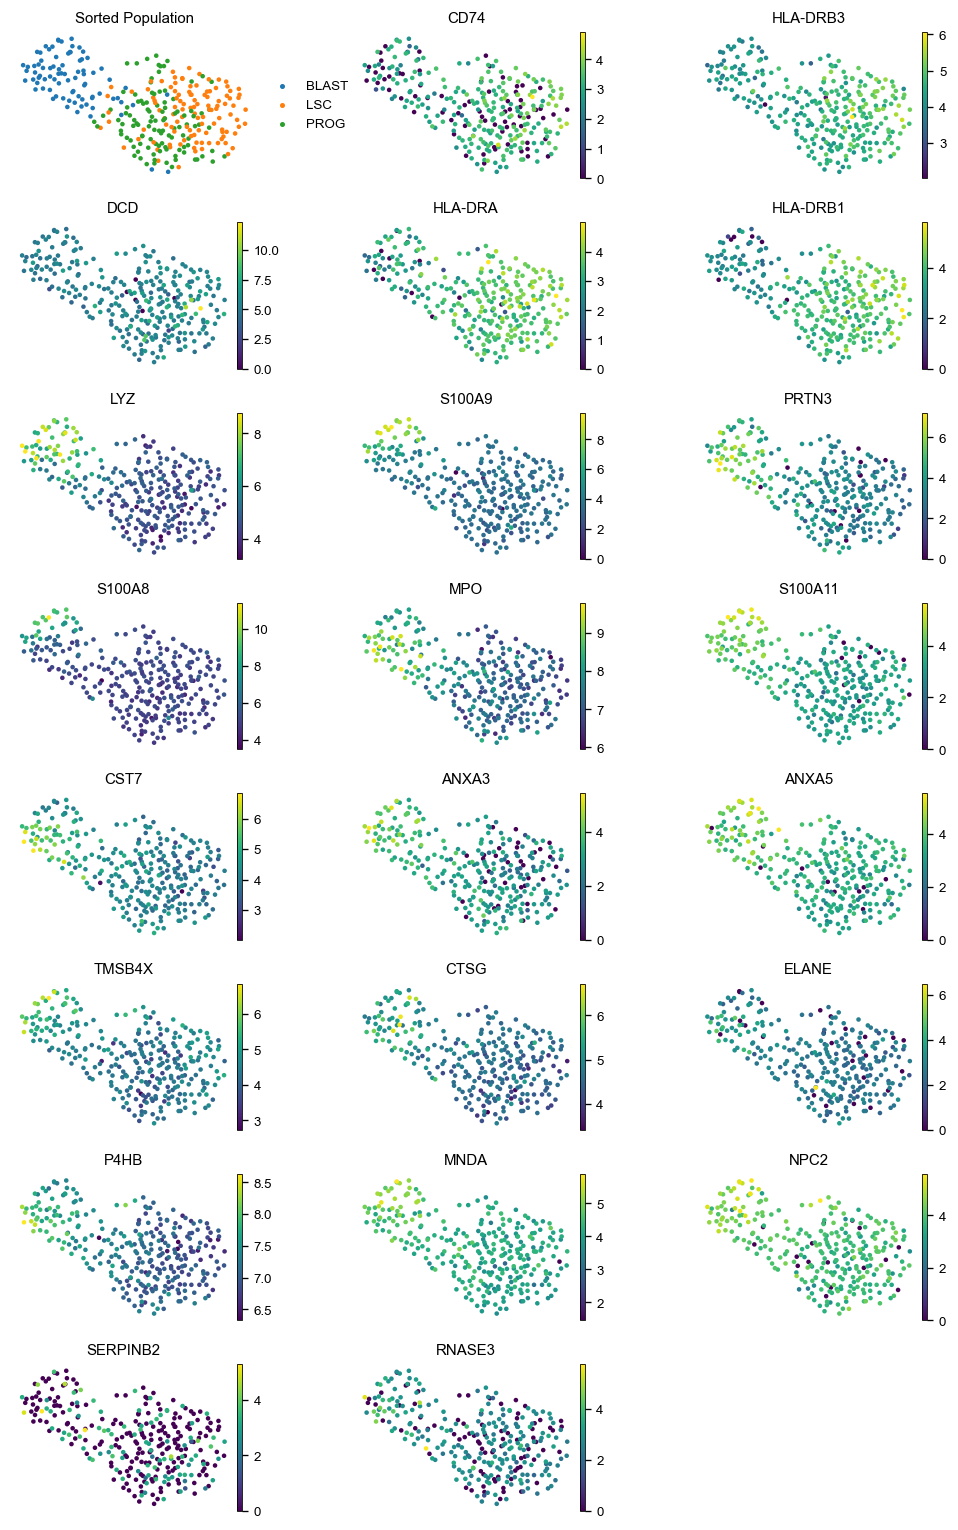

In [58]:
# plot the expression of the de-genes
genes = ['Sorted Population'] + genes_up.append(genes_down).tolist()
n_row = int((len(genes)/3)+1)
fig = plt.figure(figsize=(10, 16))
for i, p in enumerate(genes):
    ax = fig.add_subplot(n_row, 3, i+1)
    sc.pl.umap(adata, color=p, size=cellsize, show=False, ax=ax, frameon=False)
plt.subplots_adjust(wspace=0.4, hspace=0.3)
fig.savefig(res_dir + "marker_LSC_vs_BLAST.pdf", bbox_inches='tight', transparent=True)

In [59]:
# save adata
adata.write(res_dir + "300ms.h5ad")

In [60]:
os.system('jupyter nbconvert --to html 300ms.ipynb --output-dir={}'.format(res_dir))

0